# Homework 06

## Group 10

This week we are taking a look at two different CNN architectures, namely ResNet and DenseNet. After implementing simple versions of them, we will use them to perform image classification on the Cifar10 dataset we already used last week.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

Quickly recall the shape of our image data and take a look at the examples again.

In [3]:
train_images[0].shape

(32, 32, 3)

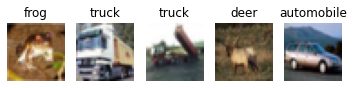

In [4]:
def class_names(label):
    """Little helper function to map a label to the corresponding word"""
    label_words = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return label_words[int(label)]

fig, ax = plt.subplots(1, 5)

for i in range(len(ax)):

    ax[i].imshow(train_images[i])
    ax[i].set_title(class_names(train_labels[i]))
    ax[i].axis("off")

# Input Pipeline

Here we are reusing the input pipeline from last week in which centered our images, normalized them and casted them into floats. The labels have been one-hot encoded and everything was zipped together and prefetched in batches.

In [5]:
# Input Pipeline

# Hyperparameters
batch_size = 64
prefetch_size = tf.data.experimental.AUTOTUNE

# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

#we normalize our data and center the pixel values around zero
train_dataset_images_centered = train_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))


# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images_centered, train_dataset_targets))
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(prefetch_size)

# repeat for the test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_images_centered = test_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))

test_dataset = tf.data.Dataset.zip((test_dataset_images_centered, test_dataset_targets))
test_dataset = test_dataset.shuffle(buffer_size=128)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(prefetch_size)


# Models

## ResNet

ResNets are used to make training easier and to help against the problems called vanishing gradient problem and exploding vanishing problem. To achieve this we redefine the layers' activation. Before, the activation was equal to the tranformation on the layer input x. Now, we additionally want so-called skip connections such that the activation of the layer equals the tranformation on the layer input x + the input x. 

If you want to take a closer look at this architecture take a look at the original paper: https://arxiv.org/pdf/1512.03385.pdf

There are some things that you need to pay attention to. Since we use the plus operator the input and the output of the layer/block must have the same shape.

For the residual network we first define the `ResidualBlock` consisting of three convolutional layers followed by batch normalization.

When it comes to building the network itself, we dicided to keep it as modular as possbile to make testing as easy as possible.
You can pass the number of ResidualBlocks you want right into the constructor of the network, which will place them after the input layer. To quickly create our ResidualBlocks we used Pythons list comprehension abilities (called inline lists in this course). You can see that we made heavy use of lists here which allowed us to end up with a structure similar to what you would achieve with the Keras Sequential Model API. All those lists are concatinated in the end so we can work through a single list in our call function.

Also, the decorator @tf.function might be new to you. By using this a TF graoh is constructed and executed. We apply this to our call function because for smaller operations it tends to be faster.

In [6]:
# ResNet Model
from tensorflow.keras import layers

class ResidualBlock(layers.Layer):
    """
    Residual block
    parameters: list of channel and kernel sizes 
    """

    def __init__(self, channels = [(10,1), (64,3), (32,1)]):
        super(ResidualBlock, self).__init__()

        assert channels[0][1] == channels [-1][1], "Kernel size of first and last layer must be the same!"

        self.layers_list = []
        for channel, kernel in channels:
            self.layers_list.append(layers.Conv2D(channel, kernel_size=kernel, padding="same"))
            self.layers_list.append(layers.BatchNormalization())
            if channel != 2:
              self.layers_list.append(layers.Activation("relu"))
                

    @tf.function
    def call(self, x, training=False):
        orig_input = x
        for layer in self.layers_list:
            x = layer(x, training=training)
        return tf.keras.layers.ReLU()(orig_input + x)


class ResNet(tf.keras.Model):
    """
    ResNet
    parameters: number of how many blocks we want to use
    """

    def __init__(self, res_block_count = 5):
        super(ResNet, self).__init__()
        self.res_block_count = res_block_count

        # Input through a convolutional layer
        input_layer = [
            layers.Conv2D(32, kernel_size=7, input_shape=(32,32,3)),
            layers.BatchNormalization(),
            layers.Activation("relu")
        ]

        # list: we increase the number of channels with respect to the block we are currently in
        # the higher the number of the block we are in the higher the number of channels
        channel_size_mid = [64, 64, 64, 128, 128, 128, 128, 128, 256, 256, 256, 256]
        channel_size_mid.extend(np.repeat(512, res_block_count - 12))

        # Add an arbitratiy number of Residual blocks
        residual_blocks = [ResidualBlock([(10,1), (channel_size_mid[i],3), (32,1)]) for i in range(self.res_block_count)]

        # Define the output layer
        output_layer = [
            layers.GlobalAveragePooling2D(),
            layers.Dense(10, activation="softmax")
        ]

        # Join all our layers together
        self.layers_list = input_layer + residual_blocks + output_layer

    @tf.function
    def call(self, x, training=False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x

We instanciate an example network with 5 ResidualBlocks and want to take a look at its structure and parameters. However we need to build our model first to create its weights. When starting the training process the model is built automatically. However, when we want to see our structure without training we need to call the `Model.build()` method and supply an input shape which will create the weights for us. Recall that our data is shaped like __(minibatch_size, pixels, pixels, channels)__, which is why we used __(64,32,32,3)__ in this example.

If you try to call `Model.summary()` before, Tensorflow will tell you to build the model first by training it on some data.

In [7]:
resnet = ResNet(20)
resnet.build((64,32,32,3))
resnet.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  4736      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
residual_block (ResidualBloc multiple                  8658      
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  8658      
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  8658      
_________________________________________________________________
residual_block_3 (ResidualBl multiple                  1678

## DenseNet

DenseNets are another architecture to solve the problems mentioned above. Here, instead of adding the input to the output of the layer we concatenate them. This way each layer is also connected to each layer after that. But if we feed every output of one layer to all other layers after that we would get an always increasing channel depth which is bad for training. 

To solve this problem we add transition and pooling layers after a few blocks. 

Take a closer look at this architecture: https://arxiv.org/pdf/1608.06993.pdf

In [8]:
# DenseNet Model

class TransitionLayer(layers.Layer):
    def __init__(self):
        super(TransitionLayer, self).__init__()
        
        self.layers_list = [
            layers.Conv2D(64, kernel_size=1, padding = 'same', activation = None),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.AveragePooling2D(strides=(2,2)),
        ]

    def call(self, x, training = False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x


class Block(layers.Layer):
    def __init__(self):
        super(Block, self).__init__()
        
        self.layers_list = [
            layers.Conv2D(16, kernel_size=3, padding = 'same', activation = None),
            layers.BatchNormalization(),
            layers.Activation("relu"),
        ]


    def call(self, x, training = False):
        
        orig_input = x
        for layer in self.layers_list:
            x = layer(x, training=training)
        x = tf.keras.layers.Concatenate()([x, orig_input])
        return x


    


class DenseBlock(layers.Layer):
    def __init__(self, number_blocks):
        super(DenseBlock, self).__init__()
        
        self.blocks=[]
        for block in range(number_blocks-1):
            self.blocks.append(Block())
        


    def call(self, x, training = False):
        
        for layer in self.blocks:
            x = layer(x, training=training)
        return x




class DenseNet(tf.keras.Model):
    def __init__(self, depth):
        super(DenseNet, self).__init__()

        
        # Define the input Layer
        input_layer = [
            layers.Conv2D(32, kernel_size=3, input_shape=(32,32,3), padding = 'same', activation = None),
            layers.BatchNormalization(),
            layers.Activation("relu")
        ]

        # Create alternating sequence of dense blocks and transition layers
        layer_list = []
        for i in range(depth - 1):
            layer_list.append(DenseBlock(12))
            layer_list.append(TransitionLayer())
        layer_list.append(DenseBlock(12)) # No transition layer after the last dense block

        # Define the output layer
        output_layer = [
            layers.GlobalAveragePooling2D(),
            layers.Dense(10, activation="softmax"),
        ]

        self.layers_list = input_layer + layer_list + output_layer

    @tf.function    
    def call(self, x, training=False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x


In [9]:
densenet = DenseNet(3)
densenet.build((64,32,32,3))
densenet.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           multiple                  896       
_________________________________________________________________
batch_normalization_61 (Batc multiple                  128       
_________________________________________________________________
activation_61 (Activation)   multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  178288    
_________________________________________________________________
transition_layer (Transition multiple                  13632     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  228976    
_________________________________________________________________
transition_layer_1 (Transiti multiple                  15

# Training

For convinience we will make our usual training functions a bit more modular. First lets define our helper functions.

In [10]:
from IPython.display import clear_output

def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()

In [11]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [12]:
import time
%matplotlib inline

def train_model(model, loss_function, epochs, learning_rate, optimizer):
    tf.keras.backend.clear_session()

    model = model

    running_average_factor = 0.95

    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []
    test_accuracies = []

    #testing once before we begin
    test_loss, test_accuracy = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset, loss_function)
    train_losses.append(train_loss)

    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        start = time.perf_counter()
        
        #print('Epoch: __ ' + str(epoch))
        #training (and checking in with training)
        running_average = 0
        for (input,target) in train_dataset:
            train_loss = train_step(model, input, target, loss_function, optimizer)
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        train_losses.append(running_average)

        #testing
        test_loss, test_accuracy = test(model, test_dataset, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        end = time.perf_counter()
        plot_performance(num_epochs, train_losses, test_losses, test_accuracies, (start, end))

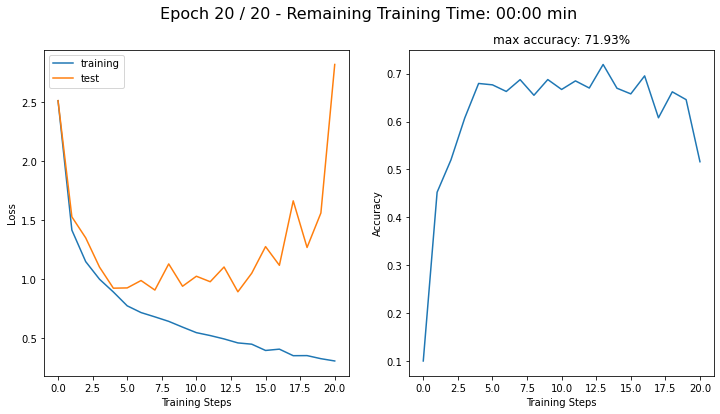

In [ ]:
### Hyperparameters
num_epochs = 20
learning_rate = 0.001

# Train on ResNet
train_model(
    model = ResNet(20),
    loss_function = tf.keras.losses.CategoricalCrossentropy(),
    epochs = num_epochs,
    learning_rate = learning_rate,
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    )


In [ ]:
### Hyperparameters
num_epochs = 30
learning_rate = 0.001

# Train on DenseNet

train_model(
     model = DenseNet(3),
     loss_function = tf.keras.losses.CategoricalCrossentropy(),
     epochs = num_epochs,
     learning_rate = learning_rate,
     optimizer = tf.keras.optimizers.Adam(learning_rate),
     )

![DenseNet Graph](dense_net.png)

# Disclaimer

Well, that was a week. In the end everything started working against us and we haven't the time (or at least the computational power to finish in time) which is why split up our training in 2 notebooks. The Graph of the densenet is therefore pasted in as a screenshot. Feel free to run it yourself as validation. Sadly we weren't able to get our ResNet over 85%, so we have to consider this home work only as "done". 